In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import optax

import numpy as np

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

# Initialize the QEC code that will be used

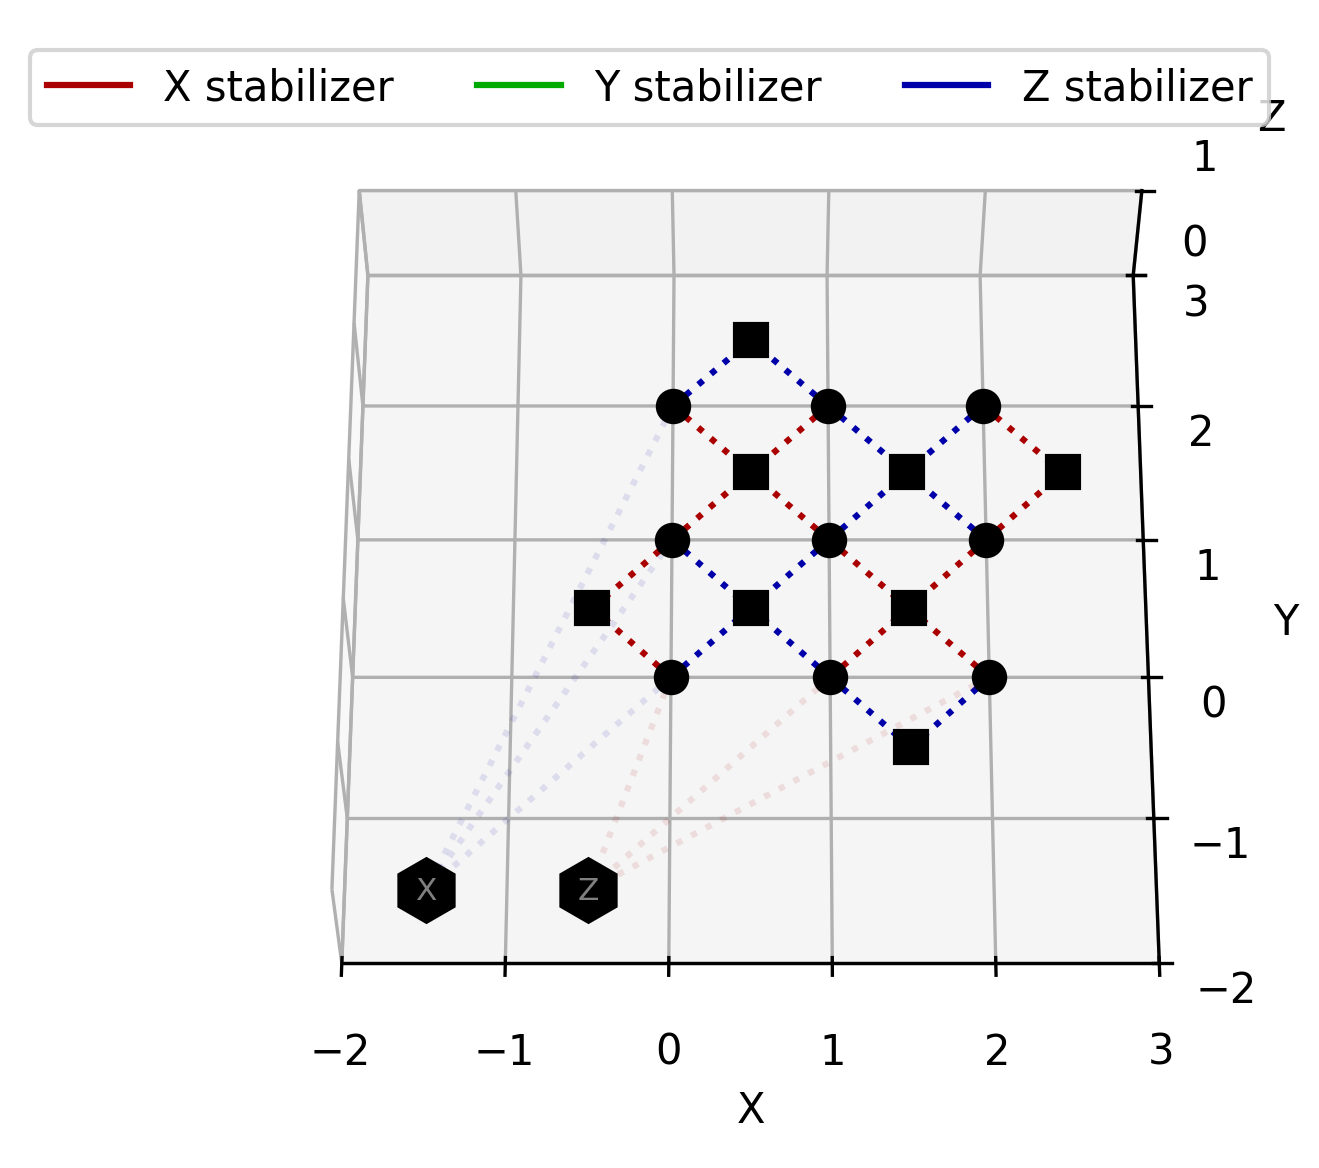

In [2]:
code_distance = 3

qec = QEC(surface_code_data_wls(d=code_distance))
info = {}
info['Mx'], info['My'], info['Mz'] = qec.transformation_matrix()
# Split into matrix for syndrome qubits in logical detectors
info['Sx'], info['Lx'] = info['Mx'][:-2], info['Mx'][-2:]
info['Sy'], info['Ly'] = info['My'][:-2], info['My'][-2:]
info['Sz'], info['Lz'] = info['Mz'][:-2], info['Mz'][-2:]
nsq, ndq = info['Sx'].shape
qec.show();

In [3]:
from functools import partial
from jax import jit, random, lax, vmap, value_and_grad, tree_map
import jax.numpy as jnp
import optax

/tmp/ipykernel_415308/254347844.py:2: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  from jax import jit, random, lax, vmap, value_and_grad, tree_map


# Create data function

In [4]:
# from matplotlib.colors import ListedColormap
# err_cmap = ListedColormap(["white", "red", "green", "blue"])

In [5]:
class QECD:

    def __init__(
        self,
        H_syndrome: dict[str, jnp.ndarray],
        H_logicals: dict[str, jnp.ndarray],
    ):
        self.nsq, self.ndq = H_syndrome['x'].shape
        self.H_syndrome = H_syndrome
        self.H_logicals = H_logicals
        self.deformation_transformations = jnp.array([
            [0, 1, 2], # I
            [1, 0, 2], # X-Y
            [0, 2, 1], # Y-Z
            [2, 1, 0], # X-Z
            [1, 2, 0], # X-Y-Z
            [2, 0, 1], # X-Z-Y
        ])
    

    @partial(jit, static_argnames=("self", "batch_size"))
    def new_batch(
        self,
        key,
        batch_size: int,
        error_probs: jnp.ndarray,
        deformation: jnp.ndarray,
    ):
        @jit
        def _single_dp(
            key,
            error_probs,
            deformation,
        ):
            # Random float that will to used to decide 
            rvs = jax.random.uniform(key, shape=(self.ndq), dtype=jnp.float32)
            error = jnp.zeros_like(rvs, dtype=jnp.int32)  # Initialize with zeros (default case)

            # Deform the noise model (instead of the code)
            code_deformation = self.deformation_transformations[deformation]
            data_qubit_error_idx = jnp.zeros_like(code_deformation, dtype=int) + jnp.arange(0,deformation.shape[0])[:, None]
            px, py, pz = error_probs[(data_qubit_error_idx, code_deformation)].T

            # Use the rvs random values to turn the porbabilities into errors
            error = jnp.where(rvs < px + py + pz, 1, error)  # Check for px+py+pz first
            error = jnp.where(rvs < py + pz, 2, error)      # Check for py+pz next
            error = jnp.where(rvs < pz, 3, error)          # Check for pz last

            # Calculate the syndromes and logicals
            syndrome = (
                jnp.matmul(self.H_syndrome['x'], error == 1, preferred_element_type=jnp.int32) +
                jnp.matmul(self.H_syndrome['y'], error == 2, preferred_element_type=jnp.int32) +
                jnp.matmul(self.H_syndrome['z'], error == 3, preferred_element_type=jnp.int32)
            ) % 2
            logical = (
                jnp.matmul(self.H_logicals['x'], error == 1, preferred_element_type=jnp.int32) +
                jnp.matmul(self.H_logicals['y'], error == 2, preferred_element_type=jnp.int32) +
                jnp.matmul(self.H_logicals['z'], error == 3, preferred_element_type=jnp.int32)
            ) % 2

            return error, syndrome, logical
        
        keys = jax.random.split(key, num=batch_size)
        data_points = vmap(
            _single_dp,
            in_axes=[0, None, None],
            out_axes=0
        )
        return data_points(keys, error_probs, deformation)

qec_data = QECD(
    H_syndrome={'x': info['Sx'], 'y': info['Sy'], 'z': info['Sz']},
    H_logicals={'x': info['Lx'], 'y': info['Ly'], 'z': info['Lz']},
)
subkey, key = jax.random.split(key)
errors, syndromes, logicals = qec_data.new_batch(
    subkey, 
    batch_size=100_000, 
    error_probs=jnp.ones(shape=(ndq,3))*jnp.array([.25,0.0,.75]), 
    deformation=jnp.arange(0, ndq) % 6
)

print("Syndromes:")
print(syndromes)
print("\nLogicals:")
print(logicals)

# plt.figure()
# plt.imshow(error, vmin=0, vmax=3, cmap=err_cmap)
# plt.show()

Syndromes:
[[0 0 0 ... 1 1 1]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 1 1 ... 0 1 1]
 [1 1 1 ... 1 1 0]
 [0 0 1 ... 1 1 0]]

Logicals:
[[1 0]
 [1 0]
 [1 0]
 ...
 [1 1]
 [1 1]
 [1 0]]


[0 0 0 0 1 1 1 1]
[1 0]


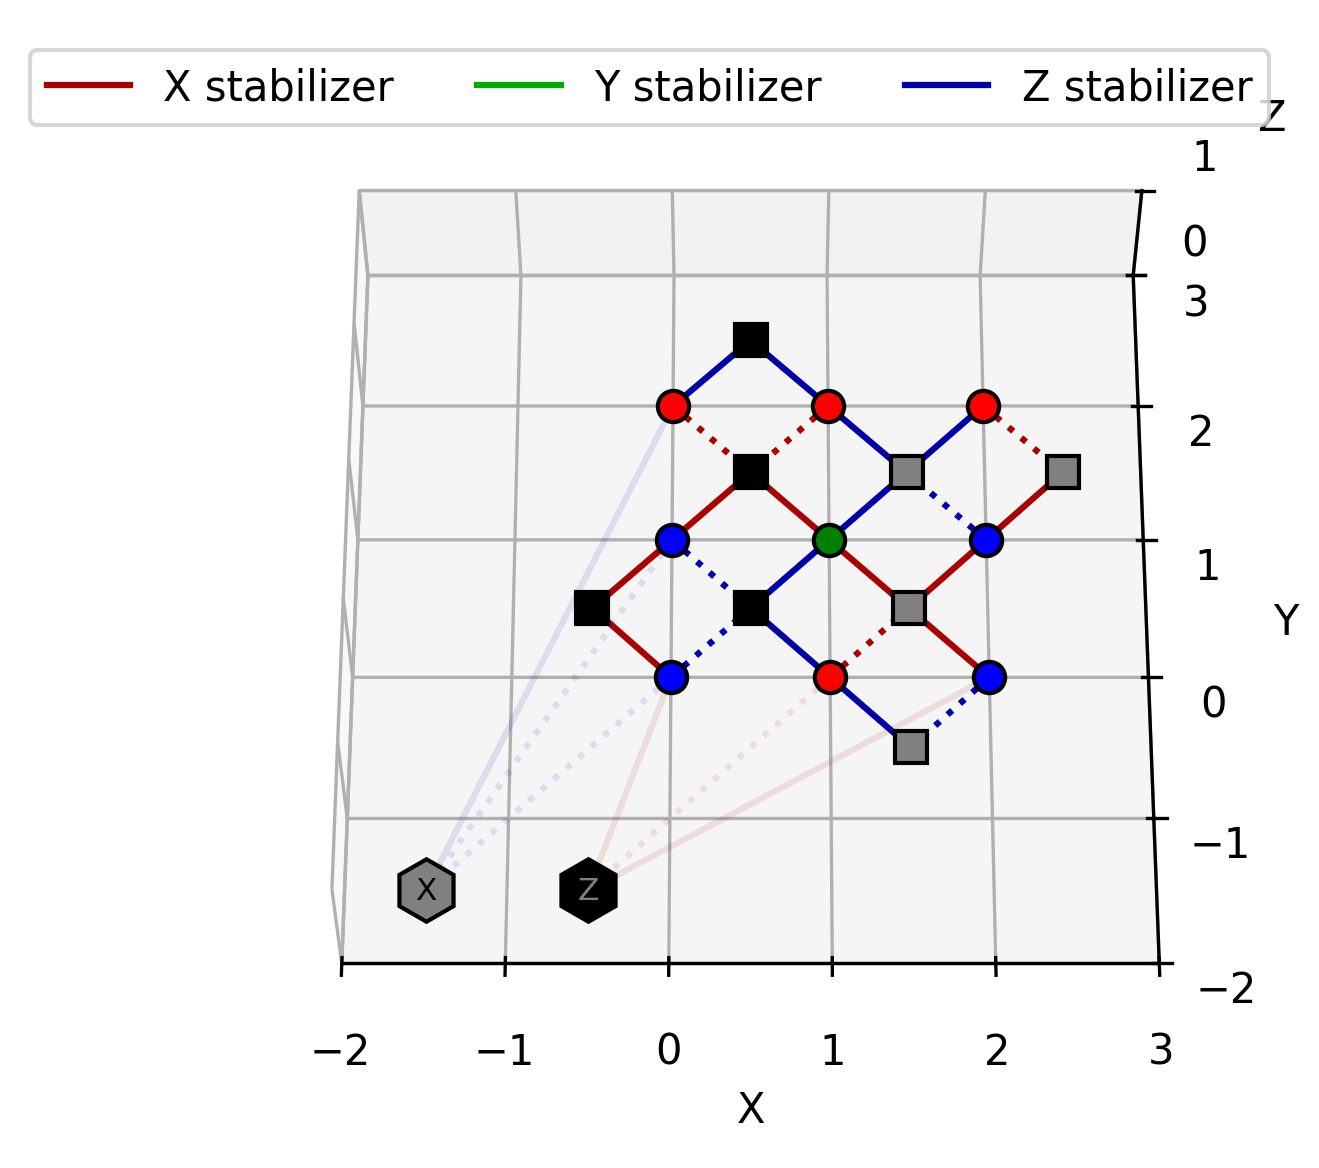

In [6]:
i = 0
qec.show(errors=errors[i]);
print(syndromes[i])
print(logicals[i])

# Create the NN

In [7]:
class FCNN:

    def __init__(
        self,
        layers: list[int],
    ):
        self.layers = layers
    

    def new_params(
        self, 
        key,
    ):
        params = {}
        params['weights'] = []
        params['biases'] = []

        for lower_layer, higher_layer in zip(self.layers[:-1], self.layers[1:]):
            key, subkey = jax.random.split(key)
            params['weights'].append(jax.random.normal(subkey,
                                                    [higher_layer, lower_layer]) /
                                    jnp.sqrt(lower_layer))

        for num_neurons in self.layers[1:]:
            params['biases'].append(jnp.zeros(num_neurons))
        
        return params
        

    @partial(jit, static_argnames=("self"))
    def _run(
        self, 
        params: dict,
        x: jnp.ndarray,
    ):
        def _run_single(
            params,
            x,
            num_layers
        ):
            for layer_idx, (w, b) in enumerate(zip(params['weights'], params['biases'])):
                x = jnp.matmul(w, x) + b
                if layer_idx < num_layers-1:
                    x = jax.nn.relu(x)
            return x  
        num_layers = len(self.layers) - 1
        _run_batch = vmap(
            _run_single,
            in_axes=[None, 0, None],
            out_axes=0
        )
        return _run_batch(params, x, num_layers)
    

    @partial(jit, static_argnames=("self"))
    def decode(
        self,
        params: dict,
        x: jnp.ndarray,
    ):
        return jnp.where(self._run(params, x) > 0, 1, 0)
    

    @partial(jit, static_argnames=("self"))
    def loss(
        self,
        params: dict,
        x: jnp.ndarray,
        y: jnp.ndarray,
    ):
        """
        Uses the Binary Cross Entropy (BCE) to evaluate the performance of the NN
        """
        return optax.sigmoid_binary_cross_entropy(
            logits=self._run(params, x),
            labels=y
        ).mean()
    

    @partial(jit, static_argnames=("self", "optimizer"))
    def update(
        self,
        params: dict, 
        x: jnp.ndarray,
        y: jnp.ndarray,
        opt_state: optax.OptState,
        optimizer: optax.GradientTransformation,
    ):
        mse_loss_batch_val_grad = value_and_grad(self.loss, argnums=0)
        mse_loss_batch_val_grad = jax.jit(mse_loss_batch_val_grad)
        loss, grads = mse_loss_batch_val_grad(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state


NN_decoder = FCNN(
    layers=[nsq, 100, 100, 50, 2]
)
subkey, key = jax.random.split(key)
params = NN_decoder.new_params(subkey)
ic(NN_decoder.loss(params, x=syndromes, y=logicals))

optimizer = optax.adam(learning_rate=1E-3)
opt_state = optimizer.init(params)
loss, new_params, opt_state = NN_decoder.update(params, x=syndromes, y=logicals, opt_state=opt_state, optimizer=optimizer)
loss

ic| NN_decoder.loss(params, x=syndromes, y=logicals): Array(0.6913967, dtype=float32)


Array(0.6913967, dtype=float32)

# Train the NN

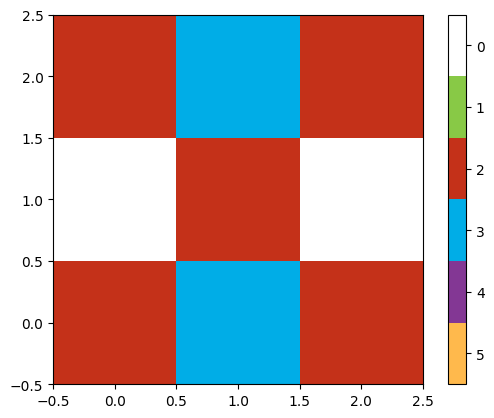

In [8]:
init_value = 1E-4
transition_steps = 5_000
decay_rate = 0.75

learning_rate = optax.exponential_decay(
    init_value,
    transition_steps,
    decay_rate
)

subkey, key = jax.random.split(key)
params = NN_decoder.new_params(subkey)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

training_batches = 1_000_000
batch_size = 32

p_tot = .01
nu = 500
error_prob = jnp.array([
    1 / (2 * (nu + 1)) * p_tot,
    1 / (2 * (nu + 1)) * p_tot,
    nu / (nu + 1) * p_tot,
])
noise_model = jnp.ones(shape=(ndq,3))*error_prob

# Pick a random clifford deformation
from matplotlib.colors import ListedColormap
deformation_cmap = ListedColormap([
    "#FFFFFF", # I
    "#88C946", # X-Y
    "#C43119", # Y-Z
    "#00ADE7", # X-Z
    "#833794", # X-Y-Z
    "#FFB94C", # X-Z-Y
])
subkey, key = jax.random.split(key)
clifford_deformation = jnp.array([2,0,2,3,2,3,2,0,2])
plt.figure()
plt.imshow(clifford_deformation.reshape(3,3).T, origin='lower', vmin=-.5, vmax=5.5, cmap=deformation_cmap)
plt.colorbar().ax.invert_yaxis()
plt.show()

In [9]:
from time import time

def train(
    key,
    data: QECD,
    model: FCNN,
    training_batches: int,
    batch_size: int,
    batch_group_size: int,
    noise_model: jnp.ndarray,
    clifford_deformation: jnp.ndarray,
    params: dict,
    opt_state: optax.OptState,
    optimizer: optax.GradientTransformation,
):
    timers = {}
    loss_data = jnp.zeros(shape=training_batches, dtype=jnp.float32)
    batch_id = 0

    while batch_id < training_batches:
        try:
            # Get data
            t0 = time()
            subkey, subkey2, key = jax.random.split(key, num=3)
            clifford_deformation = jax.random.randint(subkey2, shape=ndq, minval=0, maxval=6)
            _, syndromes, logicals = data.new_batch(
                subkey, 
                batch_group_size*batch_size, 
                noise_model, 
                clifford_deformation
            )
            timers['data-gen'] = timers.get('data-gen', 0) + time() - t0
            t0 = time()
            for i in range(batch_group_size):
                # Train on data
                a = i*batch_size
                b = a+batch_size
                loss, params, opt_state = model.update(
                    params,
                    syndromes[a:b],
                    logicals[a:b],
                    opt_state,
                    optimizer
                )
                # Save the loss score
                loss_data = loss_data.at[batch_id].set(loss)
                batch_id = batch_id + 1
            timers['training'] = timers.get('training', 0) + time() - t0
            print(f"{batch_id = } | mean = {loss_data[batch_id-batch_group_size:batch_id].mean():.4f} | std = {loss_data[batch_id-batch_group_size:batch_id].std():.4f}")
        except KeyboardInterrupt:
            print(f"Training manually stopped at {batch_id = }")
            break
    
    print(timers)
    return params, loss_data


subkey, key = jax.random.split(key)
params, loss_data = train(
    key = subkey,
    data=qec_data,
    model=NN_decoder,
    training_batches=50_000,
    batch_size=batch_size,
    batch_group_size=1000,
    noise_model=noise_model,
    clifford_deformation=clifford_deformation,
    params=params,
    opt_state=opt_state,
    optimizer=optimizer,
)

batch_id = 1000 | mean = 0.2216 | std = 0.2470
batch_id = 2000 | mean = 0.0085 | std = 0.0151
batch_id = 3000 | mean = 0.0070 | std = 0.0192
batch_id = 4000 | mean = 0.0083 | std = 0.0267
batch_id = 5000 | mean = 0.0060 | std = 0.0227
batch_id = 6000 | mean = 0.0033 | std = 0.0163
batch_id = 7000 | mean = 0.0045 | std = 0.0206
batch_id = 8000 | mean = 0.0046 | std = 0.0204
batch_id = 9000 | mean = 0.0023 | std = 0.0123
batch_id = 10000 | mean = 0.0051 | std = 0.0204
batch_id = 11000 | mean = 0.0047 | std = 0.0207
batch_id = 12000 | mean = 0.0023 | std = 0.0114
batch_id = 13000 | mean = 0.0042 | std = 0.0177
batch_id = 14000 | mean = 0.0044 | std = 0.0210
batch_id = 15000 | mean = 0.0066 | std = 0.0236
batch_id = 16000 | mean = 0.0026 | std = 0.0122
batch_id = 17000 | mean = 0.0056 | std = 0.0218
batch_id = 18000 | mean = 0.0043 | std = 0.0197
batch_id = 19000 | mean = 0.0023 | std = 0.0119
batch_id = 20000 | mean = 0.0048 | std = 0.0220
batch_id = 21000 | mean = 0.0054 | std = 0.0242
b

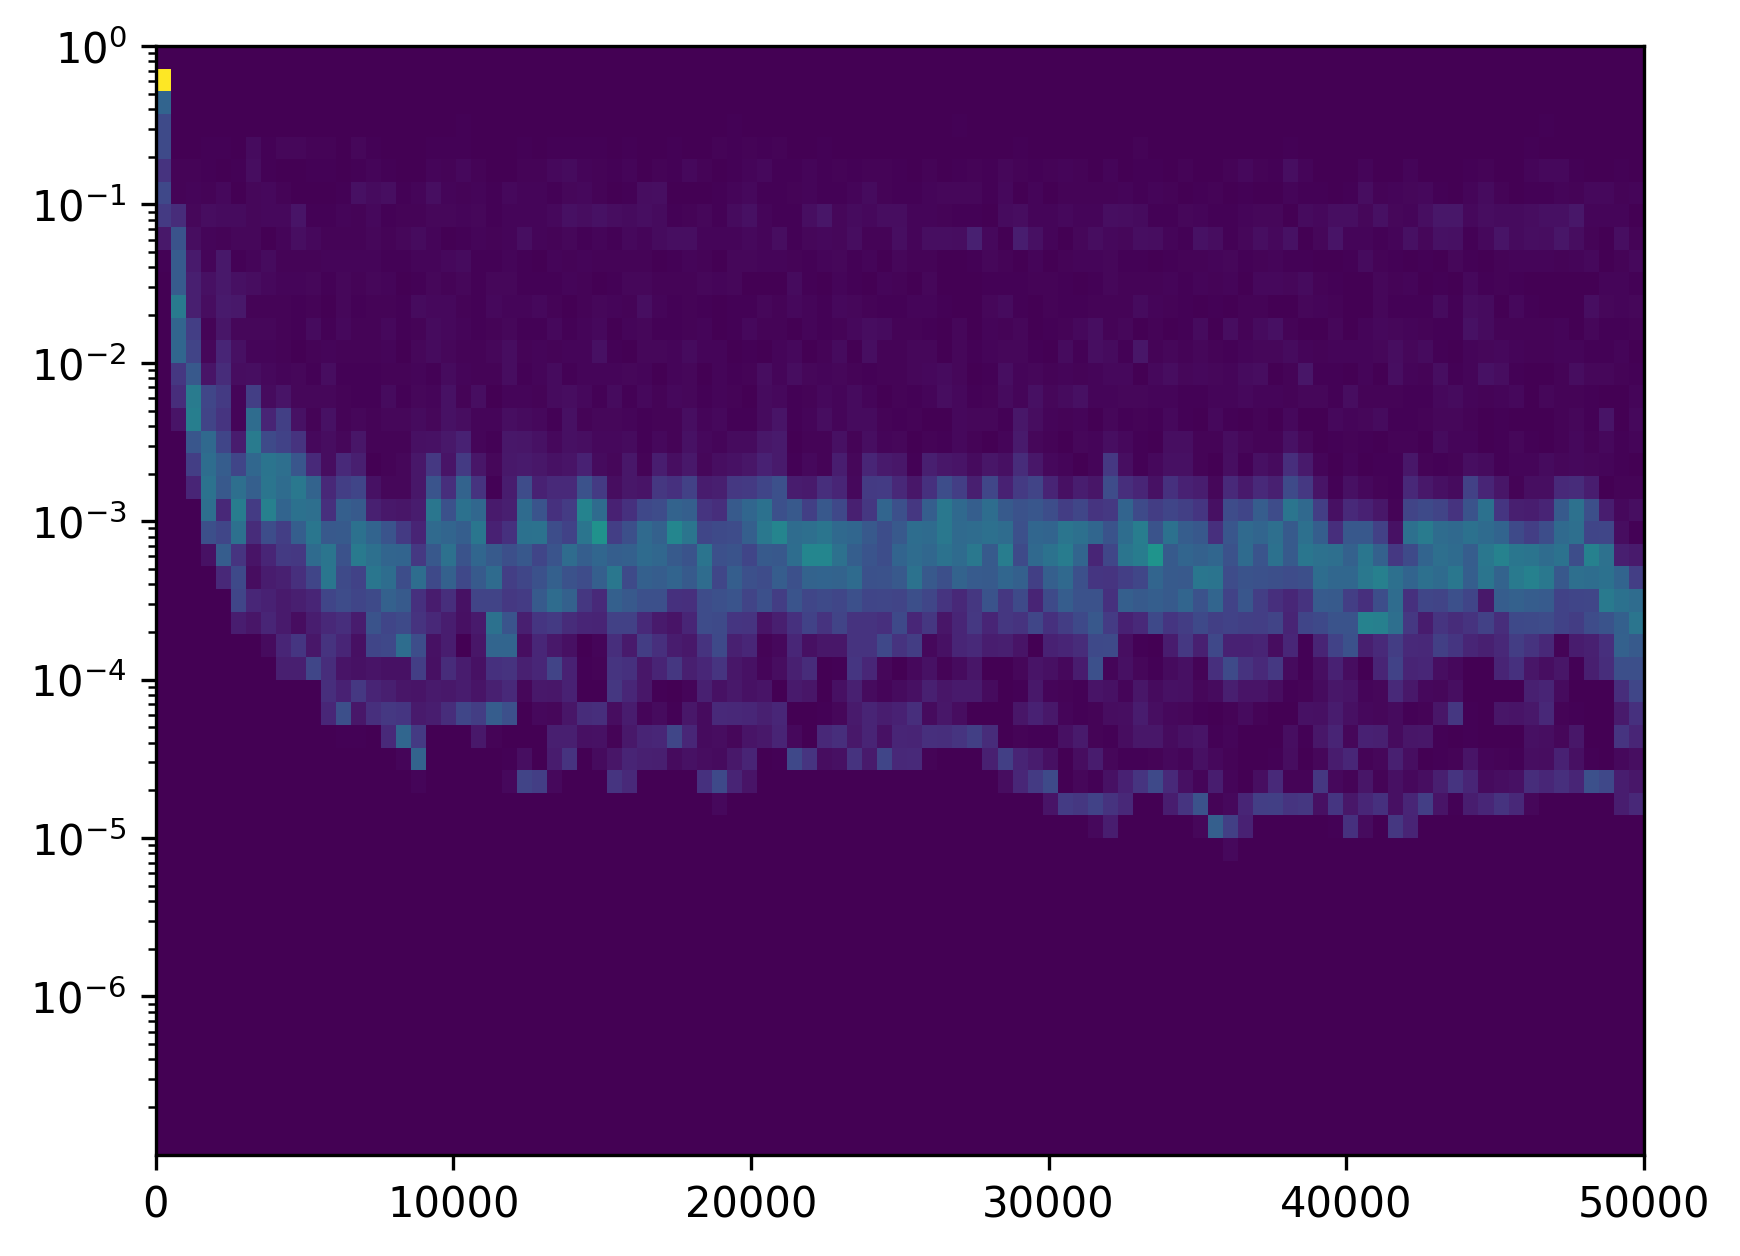

In [10]:
end = (loss_data > 0).sum()
x = jnp.arange(0, end)
y = loss_data[:end]

plt.figure(dpi=300)
plt.hist2d(x, y, bins=[
    jnp.linspace(0, end, 100),
    jnp.logspace(-7,0)
])
plt.yscale('log')
plt.show()

# Benchmark against MWPM

In [11]:
batch_size = 1_000_000

p_tot = .01
nu = 500
error_prob = jnp.array([
    1 / (2 * (nu + 1)) * p_tot,
    1 / (2 * (nu + 1)) * p_tot,
    nu / (nu + 1) * p_tot,
])
noise_model = jnp.ones(shape=(ndq,3))*error_prob

subkey, key = jax.random.split(key)
errors, syndromes, logicals = qec_data.new_batch(
    subkey, 
    batch_size, 
    noise_model, 
    clifford_deformation
)

In [12]:
NN_logicals = NN_decoder.decode(params, syndromes)

In [13]:
NN_decoder.loss(params, syndromes, logicals)

Array(0.00438377, dtype=float32)

In [14]:
# Evaluate the MWPM decoder on the same dataset
MWPM = Matching(jnp.append(info['Sx'], info['Sz'], axis=1))
decoding = MWPM.decode_batch(syndromes)
recovery = jnp.where(decoding[:,:ndq]==1, jnp.where(decoding[:,ndq:]==1, 2, 1), jnp.where(decoding[:,ndq:]==1, 3, 0))
MWPM_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], recovery)

In [15]:
NN_errors = (logicals+NN_logicals)%2
NN_rates = [
    jnp.equal(NN_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size,
    jnp.equal(NN_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size,
    jnp.equal(NN_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size,
]

MWPM_errors = (logicals+MWPM_logicals)%2
MWPM_rates = [
    jnp.equal(MWPM_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size,
    jnp.equal(MWPM_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size,
    jnp.equal(MWPM_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size,
]

In [16]:
error_prob = noise_model.mean(axis=0)

print("\t\t\tPauli-X\tPauli-Y\tPauli-Z")
print(f"Physical error rates:\t\t{error_prob[0]:7.2E}\t{error_prob[1]:7.2E}\t{error_prob[2]:7.2E}")
print(f"NN prediction error rates:\t{NN_rates[0]:7.2E}\t{NN_rates[1]:7.2E}\t{NN_rates[2]:7.2E}")
print(f"MWPM decoding error rates:\t{MWPM_rates[0]:7.2E}\t{MWPM_rates[1]:7.2E}\t{MWPM_rates[2]:7.2E}")

			Pauli-X	Pauli-Y	Pauli-Z
Physical error rates:		9.98E-06	9.98E-06	9.98E-03
NN prediction error rates:	8.14E-04	3.59E-04	4.65E-04
MWPM decoding error rates:	9.11E-04	2.10E-05	7.99E-04


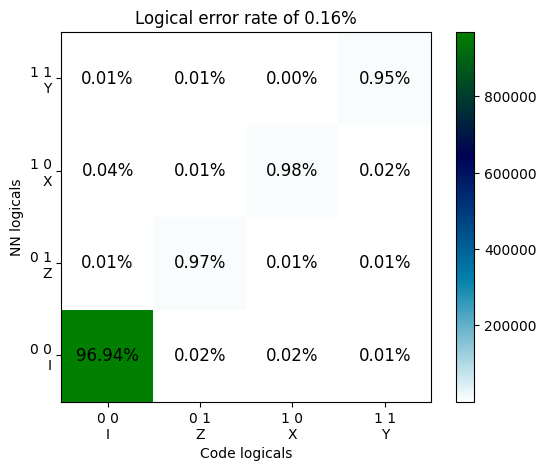

In [17]:
# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * NN_logicals[:, 0] + NN_logicals[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r')
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('Code logicals')
plt.ylabel('NN logicals')
for syndromes, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(syndromes, y, f'{count/hist2d.sum():.2%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Logical error rate of {1 - hist2d.diagonal().sum() / hist2d.sum():.2%}')
plt.show()

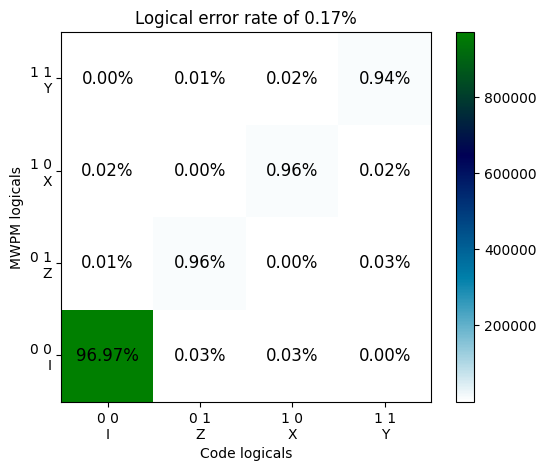

In [18]:
# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * MWPM_logicals[:, 0] + MWPM_logicals[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r')
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('Code logicals')
plt.ylabel('MWPM logicals')
for syndromes, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(syndromes, y, f'{count/hist2d.sum():.2%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Logical error rate of {1 - hist2d.diagonal().sum() / hist2d.sum():.2%}')
plt.show()

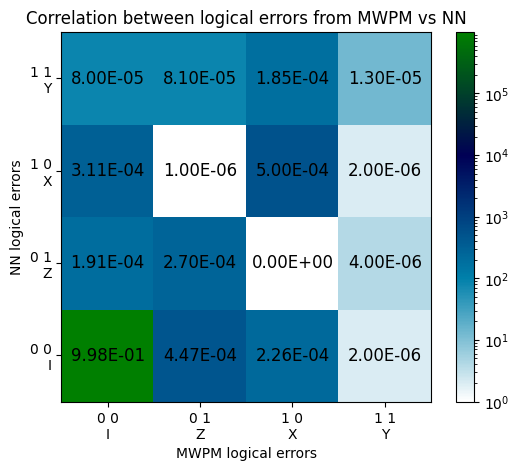

In [19]:
from matplotlib.colors import LogNorm

# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * MWPM_errors[:, 0] + MWPM_errors[:, 1]
j = 2 * NN_errors[:, 0] + NN_errors[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r', norm=LogNorm())
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('MWPM logical errors')
plt.ylabel('NN logical errors')
for syndromes, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(syndromes, y, f'{count/hist2d.sum():7.2E}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Correlation between logical errors from MWPM vs NN')
plt.show()